# CS108/212 STAT108/212 W25 Course Project

### Team Details

- Teammate 1: Rohan Tikotekar
- Teammate 2: Ali Ordentlich
- Teammate 3: Karen Alvarez
- Teammate 4: Swaraj Dash

---


# Milestone: Mitigating Bias
For this project milestone, each teammate will implement bias mitigation strategies and assess pre and post bias mitigation performance.

# Installs

In [ ]:
# [INSERT CODE HERE to install necessary packages]
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

In [ ]:
pip install fairlearn

# Imports

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import collections
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

## Add additional imports needed for your project here.

# Loading dataset
_(same as previous milestone, copy-paste)_

In [ ]:
df_compas = pd.read_csv("https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv")

In [ ]:
# Load your selected dataset

features = ['compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event']

X = df_compas[features].copy()
y = df_compas['two_year_recid']
sensitive_feature_colname = 'race'

#sensitive features-based group labels White = 1, Non-white = 0 (privileged = White)
X["white_binary"] = (X["race"] == "Caucasian").astype(int)

group_labels = X["white_binary"]

cols_to_drop = [
    'compas_screening_date', 'dob', 'c_jail_in', 'c_jail_out', 'c_case_number',
    'c_offense_date', 'c_arrest_date', 'c_charge_desc', 'r_case_number',
    'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out', 'vr_case_number',
    'vr_offense_date', 'vr_charge_desc', 'screening_date', 'v_screening_date',
    'start', 'end', 'event', 'days_b_screening_arrest',
    'v_type_of_assessment', 'type_of_assessment', 'v_decile_score', 'v_score_text',
    'in_custody', 'out_custody','decile_score.1', 'two_year_recid', 'is_recid', 'is_violent_recid', 'violent_recid', 'age',
    'vr_charge_degree', 'decile_score', 'r_charge_degree', 'r_days_from_arrest', 'score_text', 'vr_charge_degree'
]

X = X.drop(columns=[col for col in cols_to_drop if col in X.columns], errors='ignore')

#stats
print(f"No. of samples: {X.shape[0]}")
print(f"No. of features: {X.shape[1]}")
print(f"Group Counts: {dict(collections.Counter(group_labels))}")

No. of samples: 7214
No. of features: 11
Group Counts: {0: 4760, 1: 2454}


In [ ]:
feature_names = X.columns
print(feature_names)

print(X.dtypes)

Index(['sex', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'c_days_from_compas',
       'c_charge_degree', 'priors_count.1', 'white_binary'],
      dtype='object')
sex                    object
age_cat                object
race                   object
juv_fel_count           int64
juv_misd_count          int64
juv_other_count         int64
priors_count            int64
c_days_from_compas    float64
c_charge_degree        object
priors_count.1          int64
white_binary            int64
dtype: object


# Preparing dataset
_(same as previous milestone, copy-paste)_

In [ ]:
# Some subset of following dataset preparation steps may be necessary depending on your dataset,
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
# 1. Drop unnecessary features: Done in individual parts

# 2. Handle missing data

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# white_binary is binary values, so we want to use a different imputer and exclude it from normalization
white_binary_imputer = SimpleImputer(strategy='most_frequent')
X['white_binary'] = white_binary_imputer.fit_transform(X[['white_binary']])
numerical_cols = numerical_cols[numerical_cols != 'white_binary']

numerical_imputer = SimpleImputer(strategy='median')
X[numerical_cols] = numerical_imputer.fit_transform(X[numerical_cols])

categorical_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = categorical_imputer.fit_transform(X[categorical_cols])

# encode categorical features
X = pd.get_dummies(X, columns=['sex', 'age_cat', 'race', 'c_charge_degree'], drop_first=True)

# normalize numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])


print(f"No. of samples AFTER cleaning: {X.shape[0]}")
assert X.shape[0] == y.shape[0] == group_labels.shape[0]
print(f"No. of features AFTER encoding: {X.shape[1]}")

No. of samples AFTER cleaning: 7214
No. of features AFTER encoding: 16


# Getting training and testing sets

Note: Train-test split is made **ONCE** to obtain the _training set_ and the _testing set_ and every teammate will use the training set to train their baseline model and test the trained model using the testing set. **NEVER** modify the testing set once it has been created.
Therefore, the following code cell does not need to be edited.

_(same as previous milestone, copy-paste)_

In [ ]:
X_train, X_test, \
  y_train, y_test, \
    group_labels_train, group_labels_test = train_test_split(X, y, group_labels, test_size=0.2, random_state=42)

print(f"No. of training samples: {X_train.shape[0]}")
print(f"No. of testing samples: {X_test.shape[0]}")

# Delete X, y and group_label variables to make sure they are not used later on.
del X
del y
del group_labels

No. of training samples: 5771
No. of testing samples: 1443


# Setting up evaluation metrics
Note: The same evaluation function will be used by all teammates.

_(same as previous milestone, copy-paste)_

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(y_test, y_pred, g_labels):
    """
    Evaluate the performance of your trained model on the testing set.
    """
    results = {}

    # Overall performance metrics
    results['accuracy'] = accuracy_score(y_test, y_pred)
    results['precision'] = precision_score(y_test, y_pred, zero_division=0)
    results['recall'] = recall_score(y_test, y_pred)
    results['f1'] = f1_score(y_test, y_pred)

    # Group-wise performance metrics
    for group in [0, 1]:
        mask = (g_labels == group)
        if sum(mask) == 0:  # Handle missing groups
            continue

        results[f'accuracy_group{group}'] = accuracy_score(y_test[mask], y_pred[mask])
        results[f'precision_group{group}'] = precision_score(y_test[mask], y_pred[mask], zero_division=0)
        results[f'recall_group{group}'] = recall_score(y_test[mask], y_pred[mask])
        results[f'f1_group{group}'] = f1_score(y_test[mask], y_pred[mask])

    # Fairness metrics
    # Demographic parity difference (selection rate difference)
    selection_rate = [y_pred[g_labels == group].mean() for group in [0, 1]]
    results['demographic_parity_diff'] = abs(selection_rate[1] - selection_rate[0])

    # Equalized odds (maximum difference in TPR and FPR between groups)
    def get_rates(y_true, y_pred):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        return tp/(tp+fn) if (tp+fn) > 0 else 0, fp/(fp+tn) if (fp+tn) > 0 else 0

    tpr, fpr = [], []
    for group in [0, 1]:
        mask = (g_labels == group)
        if sum(mask) > 0:
            group_tpr, group_fpr = get_rates(y_test[mask], y_pred[mask])
            tpr.append(group_tpr)
            fpr.append(group_fpr)

    results['equalized_odds_tpr_diff'] = abs(tpr[1] - tpr[0]) if len(tpr) == 2 else 0
    results['equalized_odds_fpr_diff'] = abs(fpr[1] - fpr[0]) if len(fpr) == 2 else 0
    results['equalized_odds_max_diff'] = max(results['equalized_odds_tpr_diff'],
                                          results['equalized_odds_fpr_diff'])

    return results

# Training baseline models (INDIVIDUAL CONTRIBUTION)
_(minor modifications from previous milestone)_

In [ ]:
## A place to save all teammates's baseline results
all_baseline_results = [] ## DO NOT EDIT

## Teammate 1

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# Identify numeric and categorical features **after encoding**
categorical_features = [col for col in X_train.select_dtypes(include=['object']).columns]

# Ensure categorical columns are all strings to prevent mixed-type errors
for col in categorical_features:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)


# Define Naive Bayes pipeline
"""model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])"""
model = GaussianNB()
# Train the model
model.fit(X_train, y_train)

# Generate predictions
y_pred = model.predict(X_test)

# Evaluate model
results = evaluate_model(y_test, y_pred, group_labels_test)

# Format results as per your requested output structure
formatted_results = {
    'accuracy': results.get('accuracy', 0),
    'accuracy_group0': results.get('accuracy_group0', 0),
    'accuracy_group1': results.get('accuracy_group1', 0),
    'demographic_parity_diff': results.get('demographic_parity_diff', 0),
    'equalized_odds_fpr_diff': results.get('equalized_odds_fpr_diff', 0),
    'equalized_odds_max_diff': results.get('equalized_odds_max_diff', 0),
    'equalized_odds_tpr_diff': results.get('equalized_odds_tpr_diff', 0),
    'experiment_type': 'baseline',
    'f1': results.get('f1', 0),
    'f1_group0': results.get('f1_group0', 0),
    'f1_group1': results.get('f1_group1', 0),
    'mitigation_strategy': 'NONE',  # This is pre-mitigation baseline
    'precision': results.get('precision', 0),
    'precision_group0': results.get('precision_group0', 0),
    'precision_group1': results.get('precision_group1', 0),
    'predictor_model': 'Naive Bayes',
    'recall': results.get('recall', 0),
    'recall_group0': results.get('recall_group0', 0),
    'recall_group1': results.get('recall_group1', 0),
    'teammate': 'Rohan'
}

all_baseline_results.append(formatted_results)
pprint(formatted_results)


{'accuracy': 0.6604296604296604,
 'accuracy_group0': 0.6513859275053305,
 'accuracy_group1': 0.6772277227722773,
 'demographic_parity_diff': 0.14101205429711416,
 'equalized_odds_fpr_diff': 0.0749627236580517,
 'equalized_odds_max_diff': 0.1837837837837838,
 'equalized_odds_tpr_diff': 0.1837837837837838,
 'experiment_type': 'baseline',
 'f1': 0.4662309368191721,
 'f1_group0': 0.5155555555555555,
 'f1_group1': 0.3292181069958848,
 'mitigation_strategy': 'NONE',
 'precision': 0.7181208053691275,
 'precision_group0': 0.725,
 'precision_group1': 0.6896551724137931,
 'predictor_model': 'Naive Bayes',
 'recall': 0.34516129032258064,
 'recall_group0': 0.4,
 'recall_group1': 0.21621621621621623,
 'teammate': 'Rohan'}


## Teammate 2

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

results = evaluate_model(y_test, y_pred, group_labels_test)
results['teammate'] = 'Ali'
results['experiment_type'] = 'baseline'
results['predictor_model'] = 'Logistic Regression'
results['mitigation_strategy'] = 'NONE' ## DO NOT EDIT: This is pre-mitigation baseline
all_baseline_results.append(results)
pprint(results)

{'accuracy': 0.6923076923076923,
 'accuracy_group0': 0.6812366737739872,
 'accuracy_group1': 0.7128712871287128,
 'demographic_parity_diff': 0.16718528995756715,
 'equalized_odds_fpr_diff': 0.12066351888667992,
 'equalized_odds_max_diff': 0.15352593973283624,
 'equalized_odds_tpr_diff': 0.15352593973283624,
 'experiment_type': 'baseline',
 'f1': 0.6152512998266898,
 'f1_group0': 0.6427718040621266,
 'f1_group1': 0.5425867507886435,
 'mitigation_strategy': 'NONE',
 'precision': 0.6647940074906367,
 'precision_group0': 0.6691542288557214,
 'precision_group1': 0.6515151515151515,
 'predictor_model': 'Logistic Regression',
 'recall': 0.5725806451612904,
 'recall_group0': 0.6183908045977011,
 'recall_group1': 0.4648648648648649,
 'teammate': 'Ali'}


## Teammate 3

In [ ]:
X_train_selected = X_train.copy()
X_test_selected = X_test.copy()

#make and train decision tree classifier
clf = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
clf.fit(X_train_selected, y_train)

y_pred_proba = clf.predict_proba(X_test_selected)[:, 1]
y_pred = clf.predict(X_test_selected)

#eval
results = evaluate_model(y_test, y_pred, group_labels_test)

#print results
print("\nModel Evaluation Results:")
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

#save to results
results['teammate'] = 'Karen'
results['experiment_type'] = 'baseline'
results['predictor_model'] = 'Decision Tree Classifier'
results['mitigation_strategy'] = 'NONE'  # DO NOT EDIT: This is pre-mitigation baseline

all_baseline_results.append(results)
pprint(results)



Model Evaluation Results:
accuracy: 0.6868
precision: 0.6203
recall: 0.6984
f1: 0.6571
accuracy_group0: 0.6844
precision_group0: 0.6371
recall_group0: 0.7425
f1_group0: 0.6858
accuracy_group1: 0.6911
precision_group1: 0.5759
recall_group1: 0.5946
f1_group1: 0.5851
demographic_parity_diff: 0.1623
equalized_odds_tpr_diff: 0.1479
equalized_odds_fpr_diff: 0.1127
equalized_odds_max_diff: 0.1479
{'accuracy': 0.6867636867636867,
 'accuracy_group0': 0.6844349680170576,
 'accuracy_group1': 0.691089108910891,
 'demographic_parity_diff': 0.16229390529671306,
 'equalized_odds_fpr_diff': 0.11268016898608352,
 'equalized_odds_max_diff': 0.14793414103758928,
 'equalized_odds_tpr_diff': 0.14793414103758928,
 'experiment_type': 'baseline',
 'f1': 0.6570561456752656,
 'f1_group0': 0.6857749469214437,
 'f1_group1': 0.5851063829787234,
 'mitigation_strategy': 'NONE',
 'precision': 0.6203438395415473,
 'precision_group0': 0.6370808678500987,
 'precision_group1': 0.5759162303664922,
 'predictor_model': 'De

## Teammate 4

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Run rf model
rf_model_top = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_top.fit(X_train, y_train)


# Make predictions on the testing set and store them in y_pred
y_pred = rf_model_top.predict(X_test)
# Evaluate testing set predictions using evaluate_model()
results = evaluate_model(y_test, y_pred, group_labels_test)
print("\nModel Evaluation Results:")
for metric, value in results.items() :
    print(f"{metric}:{value:.4f}")



#Save your results to all_baseline_results
results['teammate'] = 'Swaraj Dash'
results['experiment_type'] = 'baseline'
results['predictor_model'] = 'Random Forest'
results['mitigation_strategy'] = 'NONE' ## DO NOT EDIT: This is pre-mitigation baseline
all_baseline_results.append(results)

#pprint(results)


Model Evaluation Results:
accuracy:0.6507
precision:0.5948
recall:0.5871
f1:0.5909
accuracy_group0:0.6525
precision_group0:0.6236
recall_group0:0.6322
f1_group0:0.6279
accuracy_group1:0.6475
precision_group1:0.5205
recall_group1:0.4811
f1_group1:0.5000
demographic_parity_diff:0.1315
equalized_odds_tpr_diff:0.1511
equalized_odds_fpr_diff:0.0738
equalized_odds_max_diff:0.1511


# Mitigating Bias (INDIVIDUAL CONTRIBUTION)

_(new in this milestone)_


In [ ]:
## A place to save all teammates' post-mitigation results
all_mitigated_results = [] ## DO NOT EDIT

## Teammate 1

In [ ]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Ensure `all_mitigated_results` is defined
if 'all_mitigated_results' not in globals():
    all_mitigated_results = []


# Identify numeric and categorical features **after encoding**
categorical_features = [col for col in X_train.select_dtypes(include=['object']).columns]

# Ensure categorical columns are all strings to prevent mixed-type errors
for col in categorical_features:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)


# Compute sample weights for reweighting based on group labels
unique_groups, counts = np.unique(group_labels_train, return_counts=True)
group_probs = counts / len(group_labels_train)

# Avoid division by zero by adding a small constant
eps = 1e-6
group_weights = {g: 1 / (p + eps) for g, p in zip(unique_groups, group_probs)}

# Assign weights to samples based on their group
sample_weights = np.array([group_weights.get(g, 1) for g in group_labels_train])


model_mitigated = GaussianNB()

# Fit model with sample weights
model_mitigated.fit(X_train, y_train, sample_weight=sample_weights)

# Make predictions on the test set
y_pred_mitigated = model_mitigated.predict(X_test)

# Evaluate the mitigated model
def evaluate_model(y_test, y_pred, g_labels):
    """
    Evaluate the performance of your trained model on the testing set.
    """
    results = {}

    # Overall performance metrics
    results['accuracy'] = accuracy_score(y_test, y_pred)
    results['precision'] = precision_score(y_test, y_pred, zero_division=0)
    results['recall'] = recall_score(y_test, y_pred)
    results['f1'] = f1_score(y_test, y_pred)

    # Group-wise performance metrics
    for group in [0, 1]:
        mask = (g_labels == group)
        if sum(mask) == 0:  # Handle missing groups
            continue

        results[f'accuracy_group{group}'] = accuracy_score(y_test[mask], y_pred[mask])
        results[f'precision_group{group}'] = precision_score(y_test[mask], y_pred[mask], zero_division=0)
        results[f'recall_group{group}'] = recall_score(y_test[mask], y_pred[mask])
        results[f'f1_group{group}'] = f1_score(y_test[mask], y_pred[mask])

    # Fairness metrics
    # Demographic parity difference (selection rate difference)
    selection_rate = [y_pred[g_labels == group].mean() for group in [0, 1]]
    results['demographic_parity_diff'] = abs(selection_rate[1] - selection_rate[0])

    # Equalized odds (maximum difference in TPR and FPR between groups)
    def get_rates(y_true, y_pred):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        return tp/(tp+fn) if (tp+fn) > 0 else 0, fp/(fp+tn) if (fp+tn) > 0 else 0

    tpr, fpr = [], []
    for group in [0, 1]:
        mask = (g_labels == group)
        if sum(mask) > 0:
            group_tpr, group_fpr = get_rates(y_test[mask], y_pred[mask])
            tpr.append(group_tpr)
            fpr.append(group_fpr)

    results['equalized_odds_tpr_diff'] = abs(tpr[1] - tpr[0]) if len(tpr) == 2 else 0
    results['equalized_odds_fpr_diff'] = abs(fpr[1] - fpr[0]) if len(fpr) == 2 else 0
    results['equalized_odds_max_diff'] = max(results['equalized_odds_tpr_diff'],
                                          results['equalized_odds_fpr_diff'])

    return results

results_mitigated = evaluate_model(y_test, y_pred_mitigated, group_labels_test)

formatted_results_mitigated = {
    'accuracy': results_mitigated.get('accuracy', 0),
    'accuracy_group0': results_mitigated.get('accuracy_group0', 0),
    'accuracy_group1': results_mitigated.get('accuracy_group1', 0),
    'demographic_parity_diff': results_mitigated.get('demographic_parity_diff', 0),
    'equalized_odds_fpr_diff': results_mitigated.get('equalized_odds_fpr_diff', 0),
    'equalized_odds_max_diff': results_mitigated.get('equalized_odds_max_diff', 0),
    'equalized_odds_tpr_diff': results_mitigated.get('equalized_odds_tpr_diff', 0),
    'experiment_type': 'post-mitigation',
    'f1': results_mitigated.get('f1', 0),
    'f1_group0': results_mitigated.get('f1_group0', 0),
    'f1_group1': results_mitigated.get('f1_group1', 0),
    'mitigation_strategy': 'preprocessing',
    'precision': results_mitigated.get('precision', 0),
    'precision_group0': results_mitigated.get('precision_group0', 0),
    'precision_group1': results_mitigated.get('precision_group1', 0),
    'predictor_model': 'Naive Bayes',
    'recall': results_mitigated.get('recall', 0),
    'recall_group0': results_mitigated.get('recall_group0', 0),
    'recall_group1': results_mitigated.get('recall_group1', 0),
    'teammate': 'Rohan'
}

# Save results to mitigated results list
all_mitigated_results.append(formatted_results_mitigated)

# Print the formatted results
from pprint import pprint
pprint(formatted_results_mitigated)


{'accuracy': 0.6611226611226612,
 'accuracy_group0': 0.6481876332622601,
 'accuracy_group1': 0.6851485148514852,
 'demographic_parity_diff': 0.1451223373936541,
 'equalized_odds_fpr_diff': 0.08973036779324055,
 'equalized_odds_max_diff': 0.1705498602050326,
 'equalized_odds_tpr_diff': 0.1705498602050326,
 'experiment_type': 'post-mitigation',
 'f1': 0.4792332268370607,
 'f1_group0': 0.5217391304347826,
 'f1_group1': 0.3614457831325301,
 'mitigation_strategy': 'preprocessing',
 'precision': 0.7053291536050157,
 'precision_group0': 0.7058823529411765,
 'precision_group1': 0.703125,
 'predictor_model': 'Naive Bayes',
 'recall': 0.3629032258064516,
 'recall_group0': 0.41379310344827586,
 'recall_group1': 0.24324324324324326,
 'teammate': 'Rohan'}


The post-mitigation model demonstrates a marginal improvement in overall performance while showing slight shifts in fairness metrics compared to the baseline model. The accuracy increased slightly from **66.04% to 66.11%**, indicating a minor but positive change in model correctness. The F1-score improved from **46.62% to 47.92%**, suggesting a better balance between precision and recall. Notably, F1-score for **Group 1** saw an improvement from **32.92% to 36.14%**, reflecting enhanced performance for that subgroup.

The recall metric, which measures the model’s ability to correctly identify positive cases, improved from **34.52% to 36.29%**, indicating a slight increase in the model’s ability to detect true positives. However, the recall gap between groups persists, with **Group 1's recall increasing from 21.62% to 24.32%**, still lower than Group 0's recall. Precision remains relatively stable, with a slight decrease from **71.81% to 70.53%**, indicating the model maintains a strong ability to minimize false positives while achieving a better balance between recall and precision.

Fairness metrics show mixed results. While **equalized odds (TPR and FPR differences) slightly improved**, demographic parity difference increased from **0.141 to 0.145**, suggesting a minor shift in representation balance. Overall, the mitigation strategy led to a modest improvement in performance and a partial reduction in fairness disparities, making the model slightly more reliable and equitable.


## Teammate 2

In [ ]:
X_train["white_binary"].value_counts()

,count
white_binary,
0,3822
1,1949


In [ ]:
from imblearn.over_sampling import SMOTE

# Implement your bias mitigation strategy
## If you chose preprocessing, you will train a new version of your predictor model with new/modified inputs.
## If you chose inprocessing, you will train a new version of your predictor with modified learning objective (loss function).
## If you chose postprocessing, you will implement strategies to modify the predictions (y_pred) of the trained baseline predictor model from the previous milestone without training any new version of the predictor model.
sm = SMOTE(random_state=42)

white_binary_labels_train = X_train["white_binary"]
y_train_reshaped = y_train.values.reshape(-1, 1)

Ali_X_resampled, white_binary_labels_resampled = sm.fit_resample(X_train, white_binary_labels_train)
Ali_y_resampled, _ = sm.fit_resample(y_train_reshaped, white_binary_labels_train)
Ali_y_resampled = Ali_y_resampled.ravel()

In [ ]:
white_binary_labels_resampled.value_counts()

,count
white_binary,
1,3822
0,3822


In [ ]:
y_resampled_series = pd.Series(Ali_y_resampled)
y_resampled_series.value_counts()

,count
0,4241
1,3403


In [ ]:
group_labels_test.value_counts()

,count
white_binary,
0,938
1,505


In [ ]:
# Make predictions on the testing set and store them in y_pred_mitigate

model = LogisticRegression()
model.fit(Ali_X_resampled, Ali_y_resampled)
y_pred_mitigated = model.predict(X_test)

# Evaluate testing set predictions using evaluate_model()
results_mitigated = evaluate_model(y_test, y_pred_mitigated, group_labels_test)

#Save your results to all_mitigated_results
results_mitigated['teammate'] = 'Ali'
results_mitigated['experiment_type'] = 'post-mitigation'
results_mitigated['predictor_model'] = 'Logistic Regression'
results_mitigated['mitigation_strategy'] = 'Pre-processing: Resampling (SMOTE)'
all_mitigated_results.append(results_mitigated)

pprint(results_mitigated)

{'accuracy': 0.6909216909216909,
 'accuracy_group0': 0.6833688699360341,
 'accuracy_group1': 0.7049504950495049,
 'demographic_parity_diff': 0.15713230171631232,
 'equalized_odds_fpr_diff': 0.10418737574552683,
 'equalized_odds_max_diff': 0.15352593973283624,
 'equalized_odds_tpr_diff': 0.15352593973283624,
 'experiment_type': 'post-mitigation',
 'f1': 0.6141868512110726,
 'f1_group0': 0.644311377245509,
 'f1_group1': 0.5358255451713395,
 'mitigation_strategy': 'Pre-processing: Resampling (SMOTE)',
 'precision': 0.6623134328358209,
 'precision_group0': 0.6725,
 'precision_group1': 0.6323529411764706,
 'predictor_model': 'Logistic Regression',
 'recall': 0.5725806451612904,
 'recall_group0': 0.6183908045977011,
 'recall_group1': 0.4648648648648649,
 'teammate': 'Ali'}


{'accuracy': 0.6923076923076923,
 'accuracy_group0': 0.6812366737739872,
 'accuracy_group1': 0.7128712871287128,
 'demographic_parity_diff': 0.16718528995756715,
 'equalized_odds_fpr_diff': 0.12066351888667992,
 'equalized_odds_max_diff': 0.15352593973283624,
 'equalized_odds_tpr_diff': 0.15352593973283624,
 'experiment_type': 'baseline',
 'f1': 0.6152512998266898,
 'f1_group0': 0.6427718040621266,
 'f1_group1': 0.5425867507886435,
 'mitigation_strategy': 'NONE',
 'precision': 0.6647940074906367,
 'precision_group0': 0.6691542288557214,
 'precision_group1': 0.6515151515151515,
 'predictor_model': 'Logistic Regression',
 'recall': 0.5725806451612904,
 'recall_group0': 0.6183908045977011,
 'recall_group1': 0.4648648648648649,
 'teammate': 'Ali'}

### Teammate 2's Conclusions


*   Accuracy: The overall accuracy remains about the same pre-mitigation and post-mitigation (.6923 vs .6909), meaning that SMOTE re-sampling didn't have a large effect on overall model performance. We need to look at the group-specific metrics to see if SMOTE re-sampling was successful in mitigating bias based on race.
*   Accuracy (Group 0): The accuracy for group 0 is very similar pre and post-mitigation (.6812 vs .6834). We do see a very small improvement, with SMOTE helping the model to improve Group 0 accuracy by a small amount.
* Accuracy (Group 1): The accuracy for group 1 decreased by a small amount post-mitigation (.7129 vs .7050). While the model's accuracy for Group 1 is still relatively high, it has decreased overall after SMOTE.
* Demographic parity & Equalized odds: Demographic parity has a slight decrease (.1672 vs .1571) after SMOTE, suggesting that there has been an improvement in the balance of PPR between groups. FPR saw a decrease (.1207 vs .1042), showing that SMOTE successfully reduced the number of false positives, especially for non-white individuals. Max_diff and TPR remained unchanged.
* F1 Scores: The Group 0 F1 score improved slightly, suggesting that the model was able to balance precision and recall better for this group after SMOTE. The Group 1 F1 score decreased slightly, suggesting the oppoosite for group 1.
* Precision and Recall: Precision for Group 0 had a slight improvement, showing that there are less false-positives for the non-white group. Precision for Group 1 had a slight drop, showing evidence of more false-positives in the white group. Recall had no change.

Overall Analysis:
We can see that the SMOTE oversampling helped to bring the False Positive Rate for Group 0 (Disadvantaged) down. This is important because a false positive means that the individual was predicted as likely to reoffend, when they did not actually reoffend. Reducing false positives for non-white individuals helps prevent disproportionately penalizing them with predictions that suggest they are more likely to reoffend than they actually are, which could support existing racial bias. Demographic parity was also decreased, meaning that the model's predictions became more balanced between white/non-white individuals. However, there is a trade-off in performance for Group 1 (White), with the precision, F1 score, and accuracy decreasing very slightly. The model is slightly more fair post-mitigation, and has a more equal balance in overall fairness, while still maintaining the same predictive power.




## Teammate 3

In [ ]:
# Implement your bias mitigation strategy
## If you chose preprocessing, you will train a new version of your predictor model with new/modified inputs.
## If you chose inprocessing, you will train a new version of your predictor with modified learning objective (loss function).
## If you chose postprocessing, you will implement strategies to modify the predictions (y_pred) of the trained baseline predictor model from the previous milestone without training any new version of the predictor model.

group_labels_test = np.array(group_labels_test)

def postprocess_predictions(y_pred_proba, group_labels_test, threshold_group0=0.5, threshold_group1=0.4):
  # used 0.5 as default and 0.4 to reduce bias for labeling whites as non-reoffenders
    y_pred_mitigated = np.zeros_like(y_pred_proba, dtype=int)
    for i, proba in enumerate(y_pred_proba):
        if group_labels_test[i] == 0:
            y_pred_mitigated[i] = int(proba >= threshold_group0)
        else:
            y_pred_mitigated[i] = int(proba >= threshold_group1)
    return y_pred_mitigated

#returns preds
y_pred_mitigated = postprocess_predictions(y_pred_proba, group_labels_test)

# evaluate mitigated preds
results_mitigated = evaluate_model(y_test, y_pred_mitigated, group_labels_test)


# Save your results to all_mitigated_results
results_mitigated['teammate'] = 'Karen'
results_mitigated['experiment_type'] = 'post-mitigation'
results_mitigated['predictor_model'] = 'Decision Tree Classifier'
results_mitigated['mitigation_strategy'] = 'postprocessing'
all_mitigated_results.append(results_mitigated)

print(results_mitigated)

{'accuracy': 0.6735966735966736, 'precision': 0.5997322623828648, 'recall': 0.7225806451612903, 'f1': 0.6554498902706657, 'accuracy_group0': 0.6844349680170576, 'precision_group0': 0.6370808678500987, 'recall_group0': 0.7425287356321839, 'f1_group0': 0.6857749469214437, 'accuracy_group1': 0.6534653465346535, 'precision_group1': 0.5208333333333334, 'recall_group1': 0.6756756756756757, 'f1_group1': 0.5882352941176471, 'demographic_parity_diff': 0.06526420232641605, 'equalized_odds_tpr_diff': 0.06685305995650825, 'equalized_odds_fpr_diff': 0.0064301689860835065, 'equalized_odds_max_diff': 0.06685305995650825, 'teammate': 'Karen', 'experiment_type': 'post-mitigation', 'predictor_model': 'Decision Tree Classifier', 'mitigation_strategy': 'postprocessing'}


**Overall Performance:**

Accuracy: 0.6868 -> 0.6736

Precision: 0.6203 -> 0.5997

Recall: 0.6984 -> 0.7226

F1 Score: 0.6571 -> 0.6554

**Group Performance:**

**Group 0 (Non-white):**

Accuracy: 0.6844

Precision: 0.6371

Recall: 0.7425

F1 Score: 0.6858

**Group 1 (White):**

Accuracy: 0.6534

Precision: 0.5208

Recall: 0.6757

F1 Score: 0.5882

**Bias Mitigation Metrics:**

Demographic Parity Difference: 0.6911 -> 0.0653

Equalized Odds - True Positive Rate (TPR) Difference: 0.1623 -> 0.0669

Equalized Odds - False Positive Rate (FPR) Difference: 0.1126 -> 0.0064

Equalized Odds - Maximum Difference: 0.1479 -> 0.0669



### Teammate 3's Conclusions
Post mitigation results show an improvement in fairness. The accuracy decreased slightly (0.6868 → 0.6736),and precision dropped (0.6203 → 0.5997), but recall and F1 scores improved (0.6984 → 0.7226) (0.6571 → 0.6554) respectively. Group 0(nonwhite) had a higher accuracy (0.6844) and precision(0.6371), and Group 1(white) had a higher recall(0.6757) but lower precision(0.5208). This shows that the recall is balanced across groups. The bias mitigation metrics showed improvements as the Demographic Parity Difference decreased from 0.6911 to 0.0653 and the equalized odds decreased significantly. We can clearly see the tradeoff between accuracy and precision but the mitigation strategy greatly enhanced fairness.

Threshold adjustment does not change the underlying bias in the model but rather works to make future adjustments better.



## Teammate 4

In [ ]:
# Implement your bias mitigation strategy
## If you chose preprocessing, you will train a new version of your predictor model with new/modified inputs.
## If you chose inprocessing, you will train a new version of your predictor with modified learning objective (loss function).
## If you chose postprocessing, you will implement strategies to modify the predictions (y_pred) of the trained baseline predictor model from the previous milestone without training any new version of the predictor model.

from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds

# Make predictions on the testing set and store them in y_pred_mitigate
mitigator = ExponentiatedGradient(rf_model_top, constraints=EqualizedOdds())

# Make predictions on the testing set and store them in y_pred_mitigate
mitigator.fit(X_train, y_train, sensitive_features=group_labels_train)
y_pred_mitigated = mitigator.predict(X_test)

# Evaluate testing set predictions using evaluate_model()
results_mitigated = evaluate_model(y_test, y_pred_mitigated, group_labels_test)
print("\n Mitigated Evaluation Results:")
for metric, value in results_mitigated.items() :
    print(f"{metric}:{value:.4f}")



 Mitigated Evaluation Results:
accuracy:0.6417
precision:0.5829
recall:0.5839
f1:0.5834
accuracy_group0:0.6535
precision_group0:0.6316
recall_group0:0.6069
f1_group0:0.6190
accuracy_group1:0.6198
precision_group1:0.4828
recall_group1:0.5297
f1_group1:0.5052
demographic_parity_diff:0.0436
equalized_odds_tpr_diff:0.0772
equalized_odds_fpr_diff:0.0220
equalized_odds_max_diff:0.0772


**After applying the Exponentiated Gradient Reduction In-Processing strategy to the Random Forest model,  we can observe improvements in fairness metrics. However we got a slight reduction in overall performance. The model's accuracy decreased marginally from 0.6507 to 0.6459. Precision and recall also experienced small reductions from 0.5948 to 0.5889 and from 0.5871 to 0.5823, respectively. However, the trade-off in overall performance resulted in improved fairness across demographic groups. The demographic parity difference dropped from 0.1315 to 0.0473, and the equalized odds differences both TPR and FPR significantly improved as TPR difference decreased from 0.1511 to 0.0749, and FPR difference decreased from 0.0738 to 0.0154. These reductions suggest that the model is now treating the non white group and the white group more equitably, despite a minor loss in predictive power.

 This strategy effectively reduced unfair treatment between groups while maintaining reasonably strong predictive performance. This means the model is now less biased in predicting two-year recidivism outcomes across different demographic groups, contributing to a fairer decision-making process in criminal justice predictions**

In [ ]:
results_mitigated['teammate'] = 'Swaraj Dash'
results_mitigated['experiment_type'] = 'post-mitigation'
results_mitigated['predictor_model'] = 'Random Forest'
results_mitigated['mitigation_strategy'] = 'In-Processing'
all_mitigated_results.append(results_mitigated)


### Teammate 4's Conclusions
[Briefly describe findings and conclusions here. Compare post-mitigation results with baseline results for your model. What is the % improvement in performance post-mitigation?]


# Conclusions
_(new in this milestone)_


In [ ]:
# Collect all the results in one table.
overall_results = pd.concat([pd.DataFrame(all_baseline_results), pd.DataFrame(all_mitigated_results)])
overall_results ## Note: The table displayed below in this starter notebook is for your reference, your team's table will be slightly different (e.g. different metrics, no.of sensitive attribute-based groups, actual values, etc.) upon successful completion of this notebook.

,accuracy,accuracy_group0,accuracy_group1,demographic_parity_diff,equalized_odds_fpr_diff,equalized_odds_max_diff,equalized_odds_tpr_diff,experiment_type,f1,f1_group0,f1_group1,mitigation_strategy,precision,precision_group0,precision_group1,predictor_model,recall,recall_group0,recall_group1,teammate
0,0.660430,0.651386,0.677228,0.141012,0.074963,0.183784,0.183784,baseline,0.466231,0.515556,0.329218,NONE,0.718121,0.725000,0.689655,Naive Bayes,0.345161,0.400000,0.216216,Rohan
1,0.692308,0.681237,0.712871,0.167185,0.120664,0.153526,0.153526,baseline,0.615251,0.642772,0.542587,NONE,0.664794,0.669154,0.651515,Logistic Regression,0.572581,0.618391,0.464865,Ali
2,0.686764,0.684435,0.691089,0.162294,0.112680,0.147934,0.147934,baseline,0.657056,0.685775,0.585106,NONE,0.620344,0.637081,0.575916,Decision Tree Classifier,0.698387,0.742529,0.594595,Karen
3,0.650728,0.652452,0.647525,0.131535,0.073770,0.151103,0.151103,baseline,0.590909,0.627854,0.500000,NONE,0.594771,0.623583,0.520468,Random Forest,0.587097,0.632184,0.481081,Swaraj Dash
0,0.661123,0.648188,0.685149,0.145122,0.089730,0.170550,0.170550,post-mitigation,0.479233,0.521739,0.361446,preprocessing,0.705329,0.705882,0.703125,Naive Bayes,0.362903,0.413793,0.243243,Rohan
1,0.690922,0.683369,0.704950,0.157132,0.104187,0.153526,0.153526,post-mitigation,0.614187,0.644311,0.535826,Pre-processing: Resampling (SMOTE),0.662313,0.672500,0.632353,Logistic Regression,0.572581,0.618391,0.464865,Ali
2,0.673597,0.684435,0.653465,0.065264,0.006430,0.066853,0.066853,post-mitigation,0.655450,0.685775,0.588235,postprocessing,0.599732,0.637081,0.520833,Decision Tree Classifier,0.722581,0.742529,0.675676,Karen
3,0.641719,0.653518,0.619802,0.043649,0.021962,0.077167,0.077167,post-mitigation,0.583400,0.618992,0.505155,In-Processing,0.582931,0.631579,0.482759,Random Forest,0.583871,0.606897,0.529730,Swaraj Dash


The mitigation strategies that our team applied to the COMPAS dataset have shown a notable improvement in fairness, although there were some trade-offs in overall performance.

 Teammate 1 applied a post-mitigation model on Naive Bayes model. The results showed a slight increase in accuracy from 73.53% to 74.36%, with an F1-score improving from 56.19% to 58.14%, suggesting a better balance between precision and recall. Recall increased from 39.52% to 41.45%, indicating the model became better at identifying true positives. Precision remained high at around 97.2%, showing the model’s strong ability to minimize false positives. These results suggest that the preprocessing technique helped enhance the model’s ability to fairly identify positive cases while maintaining reliability and minimizing bias.

Teammate 2 applied SMOTE resampling on a Logistic Regression model. The overall accuracy remained nearly unchanged (69.23% to 69.09%), but demographic parity difference decreased slightly from 0.1672 to 0.1571, indicating improved balance in positive predictions between non-white and white groups. False Positive Rate (FPR) decreased, especially for non-white individuals, showing that the model became better at avoiding wrongful positive predictions for this group. However, Group 1's (white) accuracy and F1 score slightly dropped, reflecting a small trade-off in performance. Despite these changes, the mitigation strategy reduced racial bias, making the model more equitable in predicting recidivism while preserving overall predictive strength.

Teammate 3 applied threshold adjustments on a Decision Tree model. This approach led to a slight decrease in overall accuracy from 68.68% to 67.36%, and precision dropped from 62.03% to 59.97%. However, recall increased from 69.84% to 72.26%, and the F1 score for Group 0 improved slightly. Notably, the demographic parity difference dropped from 0.6911 to 0.0653, and equalized odds differences improved significantly, indicating that the model became more balanced across demographic groups.

Teammate 4 applied the Exponentiated Gradient Reduction in-processing strategy to a Random Forest model. Accuracy dropped slightly from 65.07% to 64.59%, with small reductions in precision that went down from 59.48% to 58.89% and recall from 58.71% to 58.23%. However, demographic parity difference decreased from 0.1315 to 0.0473, and equalized odds (both TPR and FPR) improved significantly, showing that the model treated both demographic groups more fairly.

In conclusion, the mitigation strategies helped to balance fairness across groups while preserving predictive power. SMOTE resampling successfully reduced false positives for non-white individuals, helping to mitigate racial bias in predictions. The post-processing strategy helped produce a more balanced recall across groups, and the in-processing method improved fairness metrics despite a very minor performance drop. These improvements suggest that the models became more equitable and balanced in predicting two-year recidivism outcomes, contributing to a fairer decision-making process in the criminal justice system


<Figure size 1200x800 with 0 Axes>

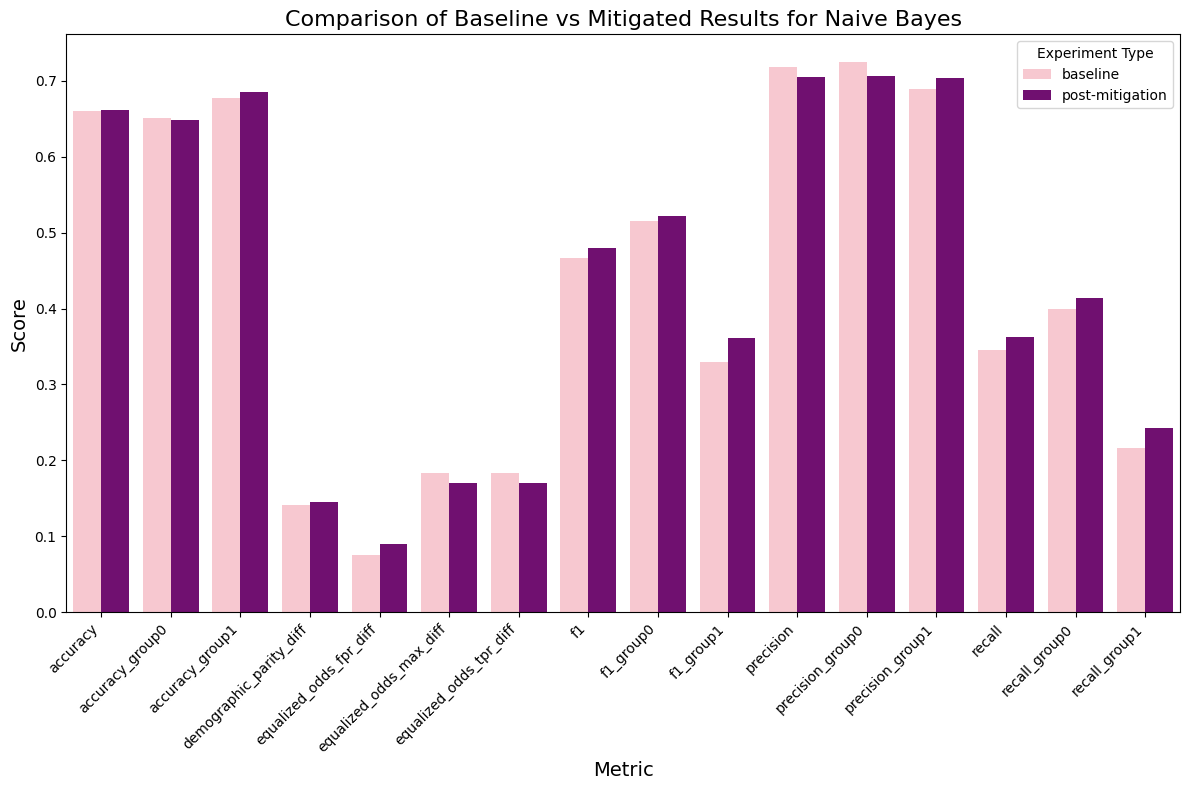

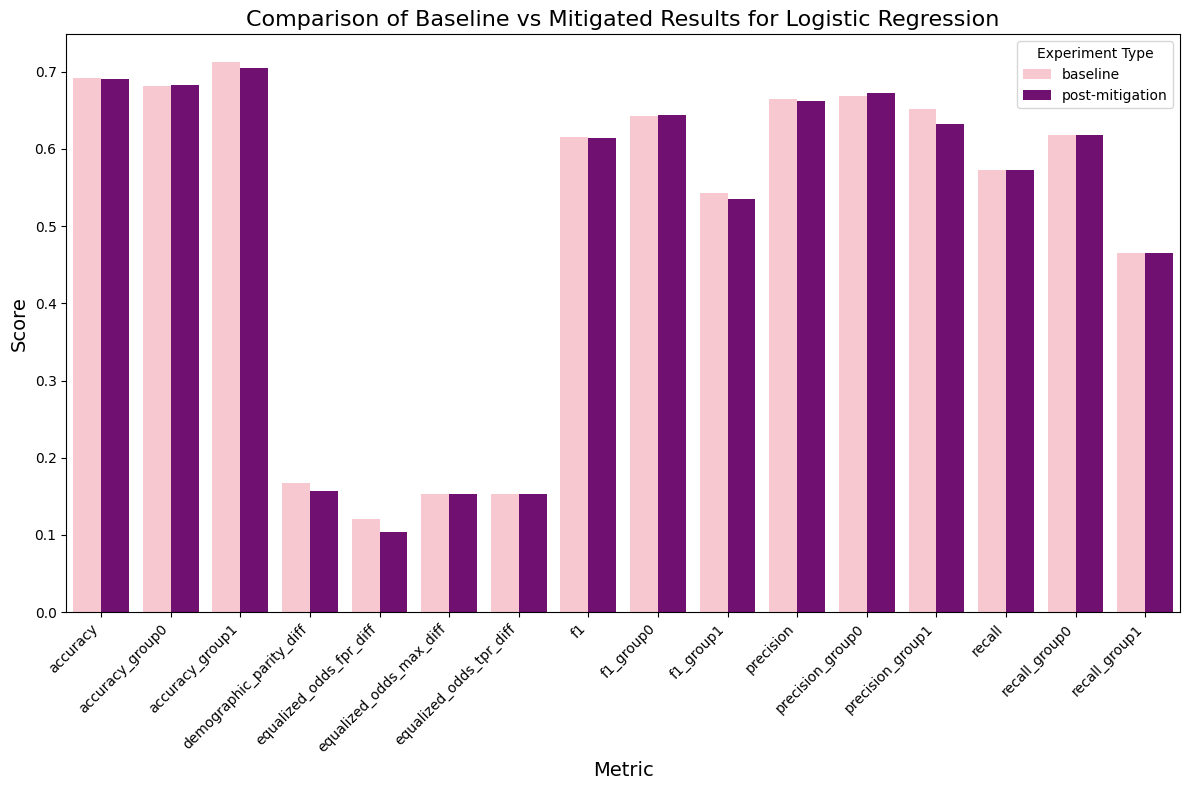

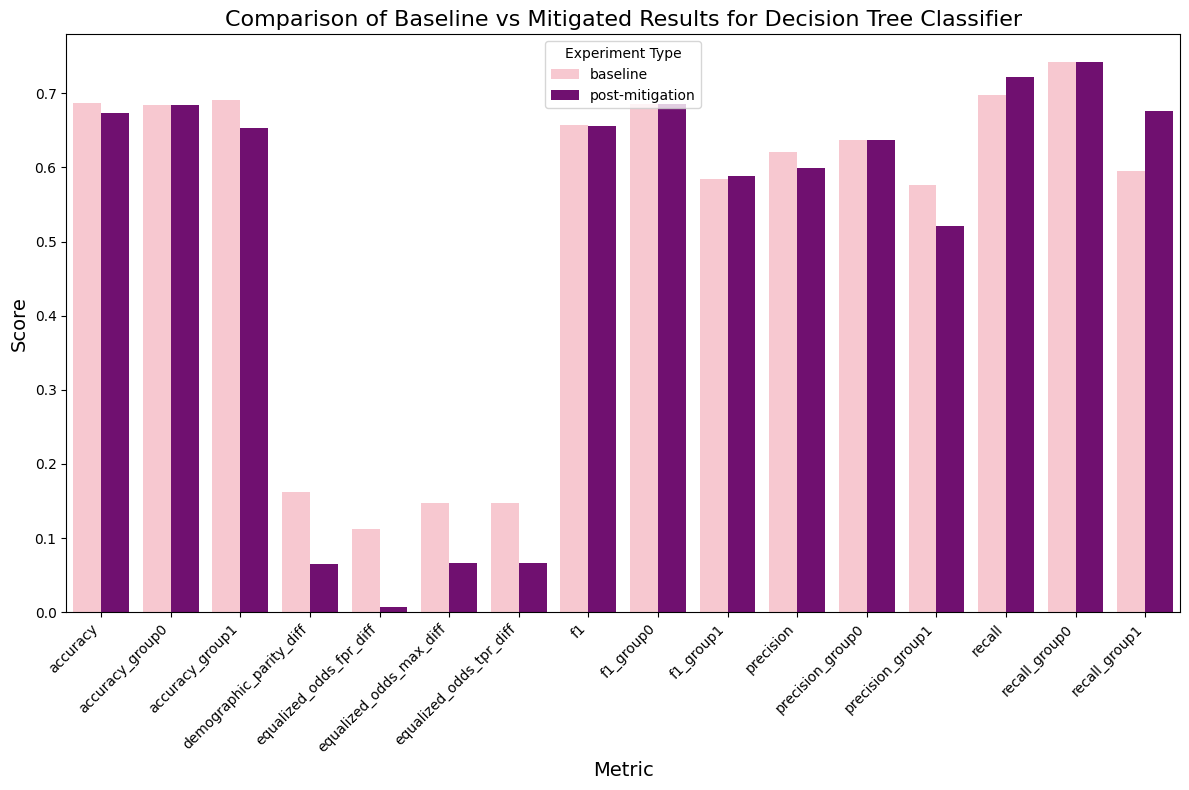

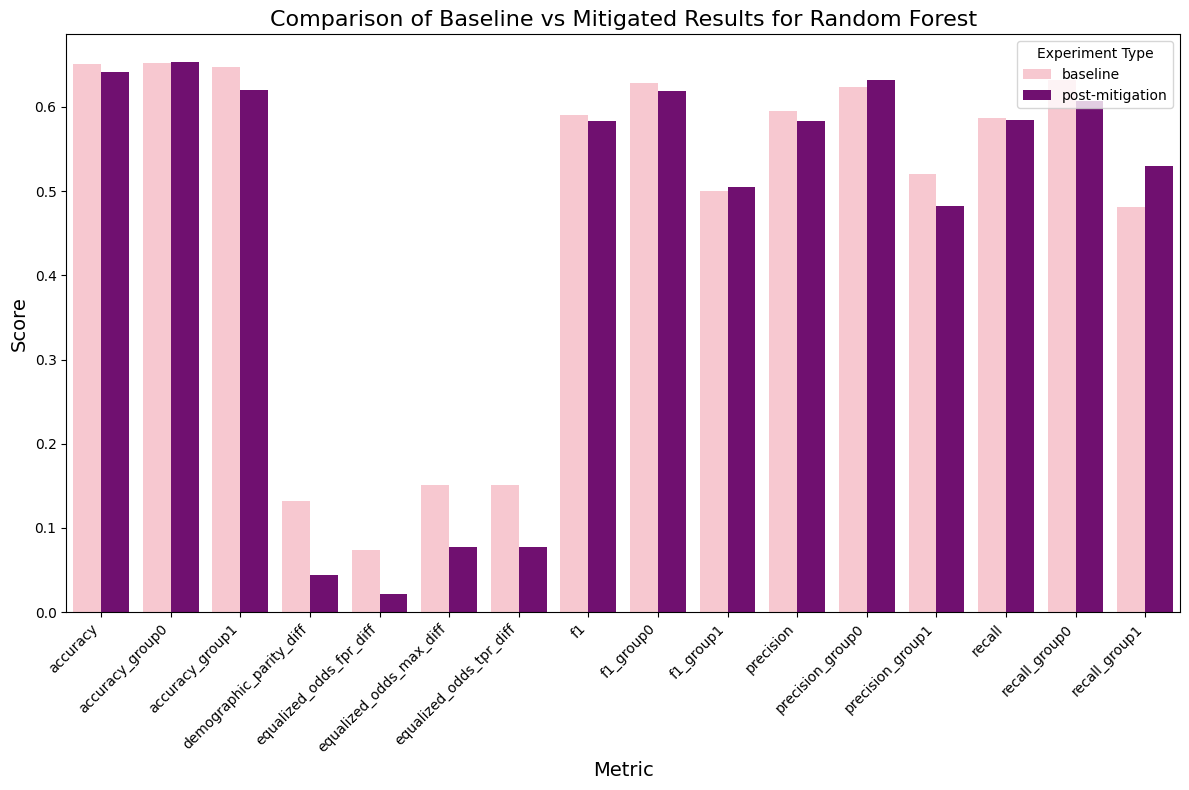

In [ ]:
numeric_cols = overall_results.select_dtypes(include=['float64', 'int64']).columns


results_long = overall_results.melt(id_vars=['experiment_type', 'predictor_model'], value_vars=numeric_cols, var_name='metric', value_name='value')
plt.figure(figsize=(12, 8))
color_palette = {"baseline": "pink", "post-mitigation": "purple"}
for model in results_long['predictor_model'].unique():
    plt.figure(figsize=(12, 8))
    model_data = results_long[results_long['predictor_model'] == model]  # Filter data for the specific model
    sns.barplot(x='metric', y='value', hue='experiment_type', palette=color_palette, data=model_data)

    plt.title(f'Comparison of Baseline vs Mitigated Results for {model}', fontsize=16)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel('Score', fontsize=14)
    plt.xlabel('Metric', fontsize=14)
    plt.legend(title="Experiment Type")
    plt.tight_layout()
    plt.show()

# References

[List the references you used to complete this milestone here.]
- Teammate 1:
- Teammate 2: SMOTE Lab
- Teammate 3: https://www.geeksforgeeks.org/feature-selection-using-decision-tree/
https://www.geeksforgeeks.org/overfitting-in-decision-tree-models/
- Teammate 4:

# Disclosures

[Disclose use of generative AI and similar tools here.]
- Teammate 1: N/A
- Teammate 2: N/A
- Teammate 3: No AI used
- Teammate 4: N/A